# MNIST Classification

## Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Fetch Dataset from Scikit Learn

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

C:\Users\ttomk\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Explore arrays of the dataset, i.e. `data` and `target`

In [3]:
X, y = mnist["data"], mnist["target"]
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (70000, 784)
Shape of y: (70000,)


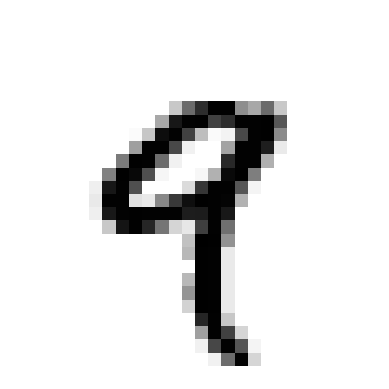

In [4]:
# Display an instance
digit = X[4]
digit_img = digit.reshape(28, 28)
plt.imshow(digit_img, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# Check if label shows 9
y[4]

'9'

In [6]:
type(y[4])

str

In [7]:
# Change y type to integer
y = y.astype(np.uint8)

The MNIST dataset is split into training (first 60000 rows) and test set (last 10000 rows)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [9]:
# This binary classifier can distinguish between two classes: 9 and not-9
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

Use Stochastic Gradient Descent classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_9)
sgd_classifier.predict([digit])

array([ True])

## Performance Measures

### Measure Accuracy with Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9456 , 0.95195, 0.9509 ])

This score of more than 94% is high, but using the dumb classifier that classifies every image in the not-9 class gives score higher than 90% because there is only about 10% images that are 9.

In [12]:
from sklearn.base import BaseEstimator

class DumbClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
dumb_clf = DumbClassifier()
cross_val_score(dumb_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.8993 , 0.8999 , 0.90335])

### Confusion Matrix

In [13]:
# Get predictions made on each test fold using 'cross_val_predict()' function
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(sgd_classifier, X_train, y_train_9, cv=3)

In [14]:
# Use 'confusion_matrix' to evaluate the performance of a classifier
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_pred)

array([[52715,  1336],
       [ 1695,  4254]], dtype=int64)

Rows are actuals and columns are predictions. The first row shows negative class (not-9).
- 52715 -> true negative
- 1336 -> false positive
- 4254 -> true positive
- 1695 -> false negative

### Compute precision and recall
- Precision: TP / (TP + FP)
- Recall: TP / (TP + FN)
- F1-score: 2 * (precision * recall) / (precision + recall) - harmonic mean of precision and recall

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_9, y_pred)

0.7610017889087657

In [16]:
recall_score(y_train_9, y_pred)

0.7150781643973777

In [17]:
f1_score(y_train_9, y_pred)

0.737325591472398

When model predicts 9s it is correct 76.1% of the time. Model detects 71.5% of the 9s.

### Precision/Recall Trade-off

Setting threshold between precision and recall trade off

In [18]:
# Get scores for each instance using decision_function() method, then set the threshold
y_scores = sgd_classifier.decision_function([digit])
y_scores

array([1468.75336355])

In [21]:
threshold = 0
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([ True])

In [22]:
threshold = 5000
y_digit_pred = (y_scores > threshold)
y_digit_pred

array([False])

Find which threshold to use
1. find y_scores for each instance using `cross_val_predict()` function
2. using y_scores compute precision and recall for all thresholds
3. plot precision and recall vs thresholds or plot precision vs recall

In [23]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_9, cv=3, method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_9, y_scores)

array([-138258.93031602, -137260.54943822, -132323.15625164, ...,
         20225.53507163,   20552.95117091,   21027.68503262])

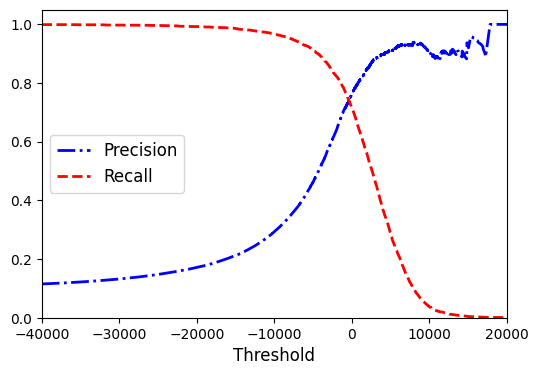

In [43]:
# Plot precision and recall vs. threshold
def plot_prec_rec_vs_thr(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-.", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "r--", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=12)
    plt.legend(fontsize=12)

plt.figure(figsize=(6, 4))
plot_prec_rec_vs_thr(precision, recall, threshold)
plt.axis([-40000, 20000, 0, 1.05])
plt.show()

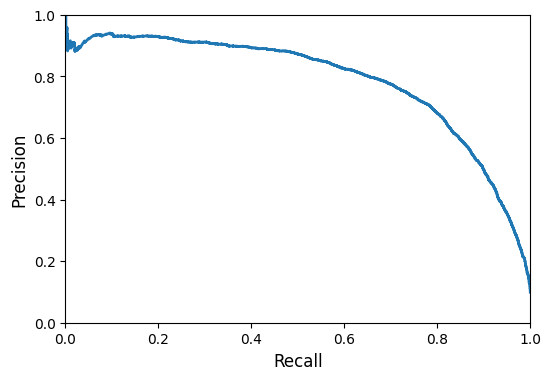

In [45]:
# Plot precision vs recall
def plot_prec_vs_rec(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    
plt.figure(figsize=(6, 4))
plot_prec_vs_rec(precision, recall)
plt.axis([0, 1, 0, 1])
plt.show()

The classifier can be improved. The curve could be closer to 1.0 in the top left corner.

### The Receiver Operating Characteristic - ROC Curve

In [46]:
# ROC curve plots tpr (recall) vs fpr (1-specificity; specificity=tnr)
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_9, y_scores)

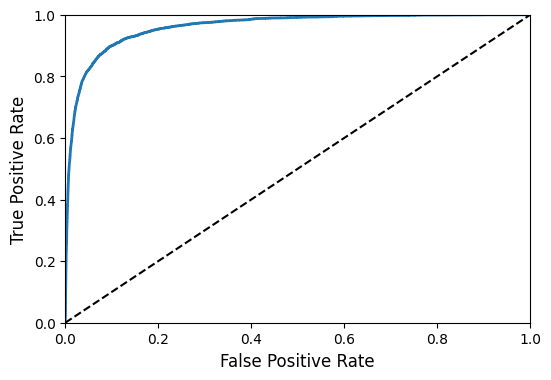

In [56]:
# Plot tpr vs fpr (ROC curve)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # diagonal line - random classifier
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(6, 4))
plot_roc_curve(fpr, tpr)
plt.show()

### The Area Under Curve - AUC

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_9, y_scores)

0.96114559368217

The classifier looks like it performs very well but the reason is having few 9s and more not-9s.

## Random Forest Classifier

In [51]:
# Build random forest classifer
from sklearn.ensemble import RandomForestClassifier

forest_classifer = RandomForestClassifier(random_state=42)
y_proba = cross_val_predict(forest_classifer, X_train, y_train_9, cv=3, method="predict_proba")

In [52]:
# Instead of scores use probabilities
y_scores_forest = y_proba[:, 1] # probability of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_9, y_scores_forest)

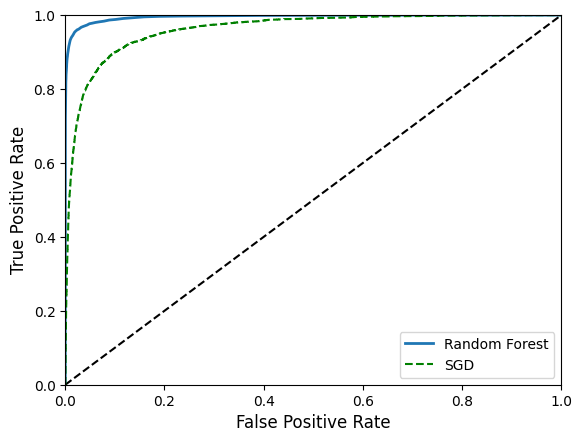

In [57]:
# Plot ROC curve for random forest classification
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.plot(fpr, tpr, "g--", label="SGD")
plt.legend()
plt.show()

In [58]:
# AUC score for Random Forest Classifier
roc_auc_score(y_train_9, y_scores_forest)

0.9952328942154235

In [60]:
# Precision scores
y_pred_forest = cross_val_predict(forest_classifer, X_train, y_train_9, cv=3)
precision_score(y_train_9, y_pred_forest)

0.9819324430479183

In [61]:
# Recall score
recall_score(y_train_9, y_pred_forest)

0.8404773911581779

## Multiclass Classification

In [62]:
# Use binary classification for multiclass classification task
from sklearn.svm import SVC

sv_clf = SVC()
sv_clf.fit(X_train, y_train)
sv_clf.predict([digit])

array([9], dtype=uint8)

In [63]:
# Find out the scores
digit_scores = sv_clf.decision_function([digit])
digit_scores

array([[-0.3072346 ,  2.72940761,  2.72002558,  4.87604398,  8.30262765,
         2.7690617 ,  0.697264  ,  7.26676236,  6.27772212,  9.31277815]])

In [64]:
# Find the max score
np.argmax(digit_scores)

9

In [65]:
sv_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
sv_clf.classes_[9]

9

The support vector classifier used one-versus-one strategy. To force one-versus-rest strategy use `OneVsRestClassifier`

In [69]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([digit])

array([9], dtype=uint8)

In [70]:
len(ovr_clf_clf.estimators_)

10

SGD classifier can handle multiclass classification and therefore, OvO or OvR is not needed.

In [71]:
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([digit])

array([9], dtype=uint8)

In [72]:
sgd_classifier.decision_function([digit])

array([[-45606.88156161, -20077.79903687, -23620.86693862,
        -11077.35532351,  -8578.08720996,  -7133.8897717 ,
        -27033.93740198,  -8312.88994614,  -3257.29010483,
          2193.22821614]])

In [73]:
# Evaluate the classifier
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [74]:
# Scale inputs to increase the accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [75]:
# Get confusion matrix
y_train_pred = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

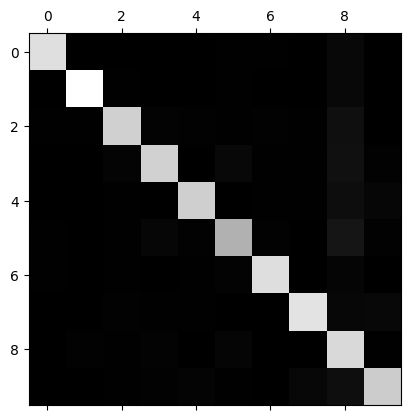

In [76]:
# Visualize confusion matrix
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

Confusion matrix plot shows that most images are on the main diagonal, meaning they are correctly classified.

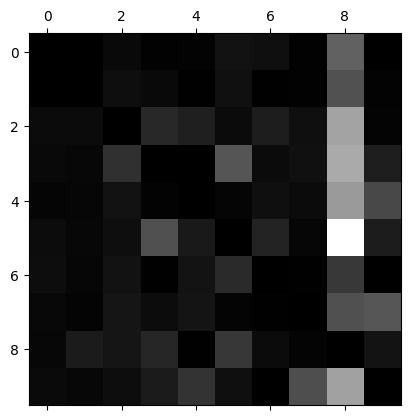

In [77]:
# Plot errors
matrix_sum = conf_matrix.sum(axis=1, keepdims=True) # sum by row
norm_conf_matrix = conf_matrix / matrix_sum
np.fill_diagonal(norm_conf_matrix, 0) # fill diagonal with zeros to keep only errors
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

Column 8 which is a prediction of 8s shows that many images are wrongly classified as 8s, but row 8 that is actual 8s are correctly classified.

## Multilabel Classification

In [78]:
# Check if 9 is small and odd number
from sklearn.neighbors import KNeighborsClassifier

y_train_small = (y_train <= 2)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_small, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([digit])

array([[False,  True]])

## Multioutput Classification

In [86]:
# Add noise to images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noise = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noise = X_test + noise
y_train_noise = X_train
y_test_noise = X_test

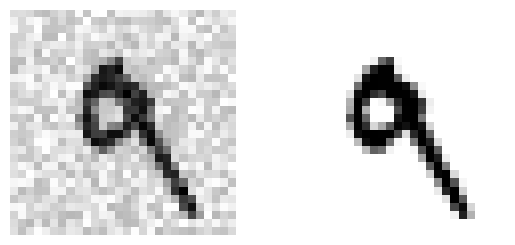

In [96]:
def plot_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

test_img_idx = 7
plt.subplot(121)
plot_digit(X_test_noise[test_img_idx])
plt.subplot(122)
plot_digit(y_test_noise[test_img_idx])
plt.show()

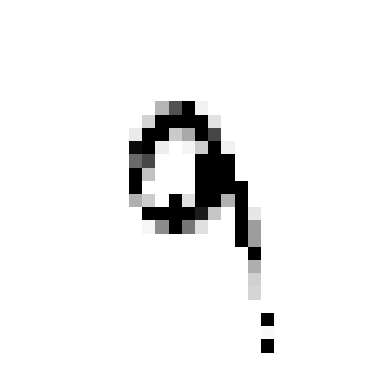

In [97]:
knn_clf.fit(X_train_noise, y_train_noise)
clean_digit = knn_clf.predict([X_test_noise[test_img_idx]])
plot_digit(clean_digit)